# 06 — Results Aggregation and Statistical Testing

This notebook will aggregate JSON reports, summary tables and statistical analyses of the models.

In [4]:
import pandas as pd, json, glob, os
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

files = glob.glob("../results/models/*.json", recursive=True)
records = []
for f in files:
    if "regression" not in f.lower():   
        continue
    if "test_report" not in f.lower():
        continue
    with open(f) as j:
        d = json.load(j)
        d["model"] = Path(f).stem.replace("_test_report","") 
        records.append(d)
df = pd.DataFrame(records)
# save df to csv
df.to_csv("../results/models/Performance_results_5yrs.csv", index=False)
df.head()


,r2_score,adjusted_r2,mae,mse,rmse,pearson_r,model
0,0.353070,0.353070,0.088093,0.009085,0.095313,0.678377,DecisionTree_regression
1,0.813676,0.813676,0.041132,0.002616,0.051151,0.907753,kNN_regression
2,0.916985,0.916985,0.030493,0.001166,0.034143,0.963424,Lasso_regression
3,0.865536,0.865536,0.035700,0.001888,0.043454,0.939591,Linear_regression
4,0.503917,0.503917,0.059361,0.006966,0.083464,0.845993,MLP_regression


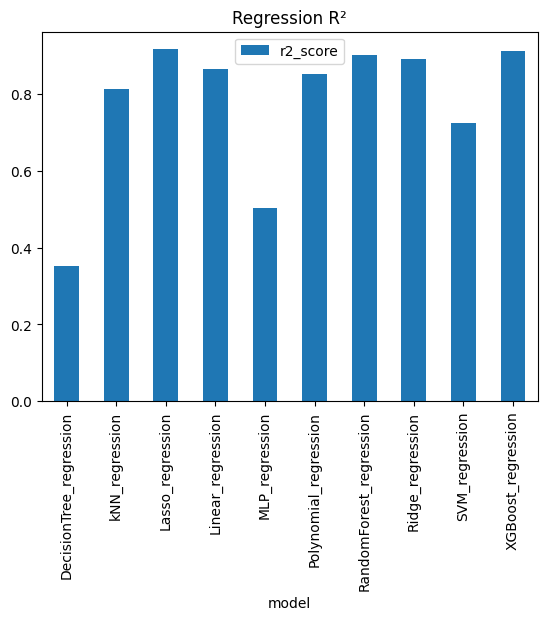

In [5]:
# Plot summary bars for regression R²
reg = df[df["model"].str.contains("regression")]
reg.plot.bar(x="model", y="r2_score", title="Regression R²")
output_path = os.path.join("../results/plots", "Regression_R^2_Table_5yrs.png")
plt.savefig(output_path, bbox_inches='tight', dpi=300)
plt.show()

RandomForest CV R² per-fold: [0.8282779938510563, 0.8329927788509267, 0.7363314487309932, 0.7249310466982277, 0.7190354947621141]
SVM CV R² per-fold: [0.2637108370839861, 0.7412785386720157, 0.687166198948741, 0.3898476357275281, 0.6757152365027821]
KNN CV R² per-fold: [0.6823502822077698, 0.8166401327161574, 0.7516651976689008, 0.3956288791880963, 0.6533000222670815]
Linear CV R² per-fold: [0.7878749914841203, 0.9823515295706446, 0.9144788719730044, 0.9517998300587105, 0.8400332016979406]
Ridge CV R² per-fold: [0.7744535946345708, 0.980179022906749, 0.9193965472742918, 0.9466054431911624, 0.8389831459544879]
Lasso CV R² per-fold: [0.8739071067900614, 0.9751488132529341, 0.9368506670993338, 0.7882929806957794, 0.7839720101450354]
Polynomial CV R² per-fold: [0.6743399351121158, 0.905787392764243, 0.8967132690011, 0.900041924458182, 0.8079972927725216]
MLP CV R² per-fold: [0.5040406259990866, 0.766784080258788, 0.904571309561197, 0.9103369582687373, 0.8775093541728629]
XGBoost CV R² per-

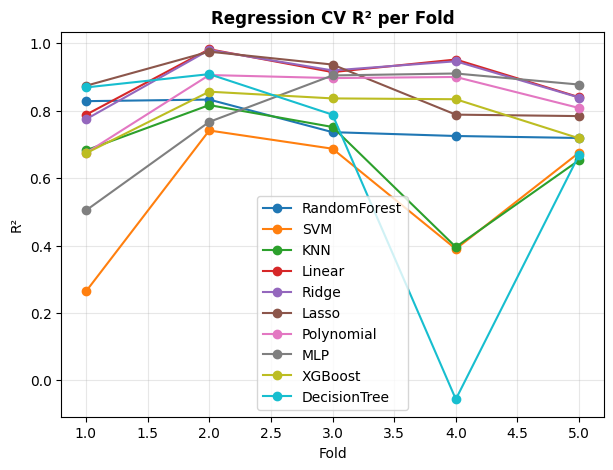


=== Paired t-test Results (RandomForest vs Others) ===
          Model  t_statistic  p_value
0           SVM        2.122    0.101
1           KNN        1.761    0.153
2        Linear       -2.800    0.049
3         Ridge       -2.600    0.060
4         Lasso       -3.508    0.025
5    Polynomial       -1.163    0.310
6           MLP       -0.247    0.817
7       XGBoost       -0.324    0.762
8  DecisionTree        0.811    0.463


In [6]:
# ---- Load CV JSONs for regression models ----
def load_cv_scores(model_name, metric_key="cv_r2_per_fold", base_dir="../results/models"):
    """Utility to load per-fold CV scores or fall back to single summary value."""
    path = Path(base_dir) / f"{model_name}_cv.json"
    if not path.exists():
        raise FileNotFoundError(f"No CV file found for {model_name} in {base_dir}")
    with open(path) as f:
        d = json.load(f)
    # Prefer per-fold scores if present, otherwise wrap single value
    return d.get(metric_key) or [d.get("cv_f1_macro") or d.get("cv_r2_mean")]

# compare regression CV R² between RandomForest and SVM
rf_cv = load_cv_scores("RandomForest_Regression", metric_key="cv_r2_per_fold")
svm_cv = load_cv_scores("SVM_Regression", metric_key="cv_r2_per_fold")
knn_cv = load_cv_scores("KNN_Regression", metric_key="cv_r2_per_fold")
linear_cv = load_cv_scores("Linear_Regression", metric_key="cv_r2_per_fold")
ridge_cv = load_cv_scores("Ridge_Regression", metric_key="cv_r2_per_fold")
lasso_cv = load_cv_scores("Lasso_Regression", metric_key="cv_r2_per_fold")
poly_cv = load_cv_scores("Polynomial_Regression", metric_key="cv_r2_per_fold")
mlp_cv = load_cv_scores("MLP_Regression", metric_key="cv_r2_per_fold")
xgb_cv = load_cv_scores("XGBoost_Regression", metric_key="cv_r2_per_fold")
dt_cv = load_cv_scores("DecisionTree_Regression", metric_key="cv_r2_per_fold")

Regress_models_cv = {
    "RandomForest": rf_cv,
    "SVM": svm_cv,
    "KNN": knn_cv,
    "Linear": linear_cv,
    "Ridge": ridge_cv,
    "Lasso": lasso_cv,
    "Polynomial": poly_cv,
    "MLP": mlp_cv,
    "XGBoost": xgb_cv,
    "DecisionTree": dt_cv
}

for model, scores in Regress_models_cv.items():
    print(f"{model} CV R² per-fold: {scores}")

paired_test_results = {}
# ---- Paired t-test ----
for model, scores in Regress_models_cv.items():
    # calculate paired t-test against RandomForest
    if model == "RandomForest":
        continue
    if len(rf_cv) == len(scores) and len(rf_cv) > 1:
        t, p = ttest_rel(rf_cv, scores)
        print(f"Paired t-test (RF vs {model}): t={t:.3f}, p={p:.3f}")
        paired_test_results[model] = {"t_statistic": t, "p_value": p}
    else:
        print(f"Not enough per-fold values for t-test (RF vs {model}, need ≥2 and equal length).")


# Save 
cv_df = pd.DataFrame({
    "Fold": range(1, len(rf_cv) + 1),
    "RandomForest": rf_cv,
    "SVM": svm_cv,
    "KNN": knn_cv,
    "Linear": linear_cv,
    "Ridge": ridge_cv,
    "Lasso": lasso_cv,
    "Polynomial": poly_cv,
    "MLP": mlp_cv,
    "XGBoost": xgb_cv,
    "DecisionTree": dt_cv
}).melt(id_vars="Fold", var_name="Model", value_name="R²")

# ---- Plot per-fold comparison ----
plt.figure(figsize=(7, 5))
for model in cv_df["Model"].unique():
    subset = cv_df[cv_df["Model"] == model]
    plt.plot(subset["Fold"], subset["R²"], marker="o", label=model)

plt.title("Regression CV R² per Fold", fontsize=12, weight="bold")
plt.xlabel("Fold")
plt.ylabel("R²")
plt.legend()
plt.grid(alpha=0.3)

# ---- Save to file ----
output_path = Path("../results/plots") / "Regression_CV_R2_Comparison_5yrs.png"
plt.savefig(output_path, bbox_inches="tight", dpi=300)
plt.show()

# create table displaring paired t-test results
# ---- Convert t-test results to DataFrame ----
paired_df = pd.DataFrame.from_dict(paired_test_results, orient="index")
paired_df.index.name = "Model"
paired_df.reset_index(inplace=True)

# Round for readability
paired_df["t_statistic"] = paired_df["t_statistic"].round(3)
paired_df["p_value"] = paired_df["p_value"].round(3)

print("\n=== Paired t-test Results (RandomForest vs Others) ===")
print(paired_df)

# ---- Save as JSON and CSV ----
output_path_json = Path("../results/models") / "Regression_CV_R2_Paired_TTest_Results_5yrs.json"
output_path_csv = Path("../results/models") / "Regression_CV_R2_Paired_TTest_Results_5yrs.csv"

with open(output_path_json, "w") as f:
    json.dump(paired_test_results, f, indent=2)

paired_df.to_csv(output_path_csv, index=False)

